In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso , LassoCV
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings 
warnings.filterwarnings('ignore')


## 2 Research Questions

There are two main goals for this case study:

#### 1. Number of deaths vary drastically across State. We want to find out how State relates to the death rate

#### 2. COVID-19 seems to target elder people’s lives. Is there evidence in our data to show that proportion of elder people indeed relates to the death at county level?

## 3 Data Prep

### 3.1

- The death rate is calculated as: death_rate = $\frac{deaths + 1}{population + 2}$

- We then apply the logarithm: log death rate = log(death_rate)

- Adding 1 to deaths avoids log(0) for counties with no deaths

- Log transformation helps normalize the distribution

- Coefficients can be interpreted as percentage changes

In [21]:
cc = pd.read_csv('covid_county_midterm.csv')

print(cc.head(3))
print(cc.shape)
print(cc.columns)
print(cc.dtypes)
print(cc.describe())
print(cc.isnull().sum())


    FIPS  cum_deaths  log_death_rate State      County  MedHHInc  \
0  10001         121       -7.301059    DE        Kent     54980   
1  10003         353       -7.364169    DE  New Castle     69562   
2  10005         236       -6.895986    DE      Sussex     59821   

   PerCapitaInc  PovertyUnder18Pct  PovertyAllAgesPct  Deep_Pov_All  ...  \
0         28100               19.6               13.8      5.701350  ...   
1         35847               15.5               11.6      5.907269  ...   
2         33983               21.6               12.3      4.091969  ...   

   FarmDependent2003  ManufacturingDependent2000  LowEducation2000  \
0                  0                           0                 0   
1                  0                           0                 0   
2                  0                           0                 0   

   RetirementDestination2000  PersistentPoverty2000  Noncore2013  \
0                          0                      0            0   
1    

In [22]:

cc_sub = cc[['log_death_rate', 'State', 'Deep_Pov_All', 'PovertyAllAgesPct', 'PerCapitaInc', 'UnempRate2019', 'PctEmpFIRE', 'PctEmpServices',
             'PopDensity2010', 'Age65AndOlderPct2010', 'WhiteNonHispanicPct2010', 'HiCreativeClass2000' ]].copy()

print(f"Dataset shape: \n{cc_sub.shape}")
print(f"\nMissing values and types:\n{cc_sub.isnull ().sum(), cc_sub.dtypes}")
print(f"\nBasic statistics :\n{cc_sub.describe ()}")



Dataset shape: 
(3016, 12)

Missing values and types:
(log_death_rate             0
State                      0
Deep_Pov_All               0
PovertyAllAgesPct          0
PerCapitaInc               0
UnempRate2019              0
PctEmpFIRE                 0
PctEmpServices             0
PopDensity2010             0
Age65AndOlderPct2010       0
WhiteNonHispanicPct2010    0
HiCreativeClass2000        0
dtype: int64, log_death_rate             float64
State                       object
Deep_Pov_All               float64
PovertyAllAgesPct          float64
PerCapitaInc                 int64
UnempRate2019              float64
PctEmpFIRE                 float64
PctEmpServices             float64
PopDensity2010             float64
Age65AndOlderPct2010       float64
WhiteNonHispanicPct2010    float64
HiCreativeClass2000          int64
dtype: object)

Basic statistics :
       log_death_rate  Deep_Pov_All  PovertyAllAgesPct  PerCapitaInc  \
count     3016.000000   3016.000000        3016.000000  

## 4 EDA 

a) Create the median log death rate by State. Show a sorted bar plot (not histogram) of the median log death rate by State, displaying only the top 15 states. Use no more than three sentences to summarize what this plot reveals about variation across states

Results: Median log death rates vary widely across states, with a small group clearly higher than the rest.
The distribution is skewed: the top states stand out while many others cluster at lower levels.
These gaps likely reflect differences in population, lifestyles, timing/strength of interventions, and reporting/testing practices. 

for example: Interpreting natural log (what numpy’s log uses): log(death_rate) = −6 ⇒ death_rate ≈ e^(−6) ≈ 0.00248 deaths per person. As “per 100k,” that’s ≈ e^(−6) × 100,000 ≈ 248

b) Two-sentence note

The violin shows each state’s full distribution revealing skewness, and tails, nuances that a boxplot can hide. High‑median states also tend to have wider right tails, indicating more counties with elevated log death rates. 

Brief interpretation:

Compared to a boxplot, the violins reveal distribution shape within states—showing skewness, heavy tails, and possible multi-modality (multiple peaks) rather than just quartiles. Several high-median states also exhibit wider violins on the high side, indicating a dense concentration of higher county-level log death rates with long right tails.

c) Calculate and report the coefficient of variation (CV) of the average log death rate across states. What does this CV value tell you about the relative variability? (1-2 sentences). 

The CV is low, so we can say the average log death rates for all states has a 8.9% relative variability around the mean. The spread is small relative to the overall level on the log scale which varies from ~-11 to ~-6.  

The CV reports relative variability: a larger CV means the state-average log death rates vary more widely relative to their mean. Values near zero imply little relative dispersion, while higher values indicate substantial cross-state heterogeneity.

Hint: CV = $\frac{standard deviation}{mean}$



,State,median_log_death_rate
29,NJ,-6.416780
17,MA,-6.582380
23,MS,-6.640278
16,LA,-6.707223
5,CT,-6.917811
26,ND,-6.964608
6,DC,-6.994671
38,SC,-7.008316
9,GA,-7.041520
2,AZ,-7.067130


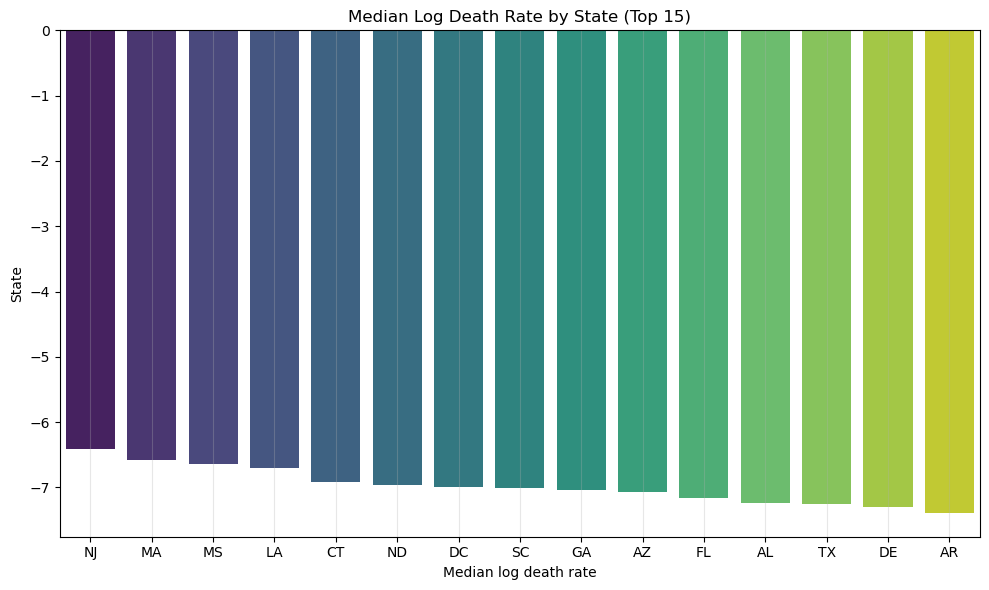

In [23]:
# 4a)
# Median log death rate by State (Top 15)

median_by_state = (
    cc_sub.groupby('State', as_index=False)['log_death_rate'].median()
    .rename(columns={'log_death_rate': 'median_log_death_rate'})
    .sort_values('median_log_death_rate', ascending=False)
)

# Top 15 states
top15 = median_by_state.head(15)

# Bar plot (sorted) — top at the top
plt.figure(figsize=(10, 6))
sns.barplot(data=top15, y='median_log_death_rate', x='State', palette = 'viridis')
plt.title('Median Log Death Rate by State (Top 15)')
plt.xlabel('Median log death rate')
plt.ylabel('State')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

top15

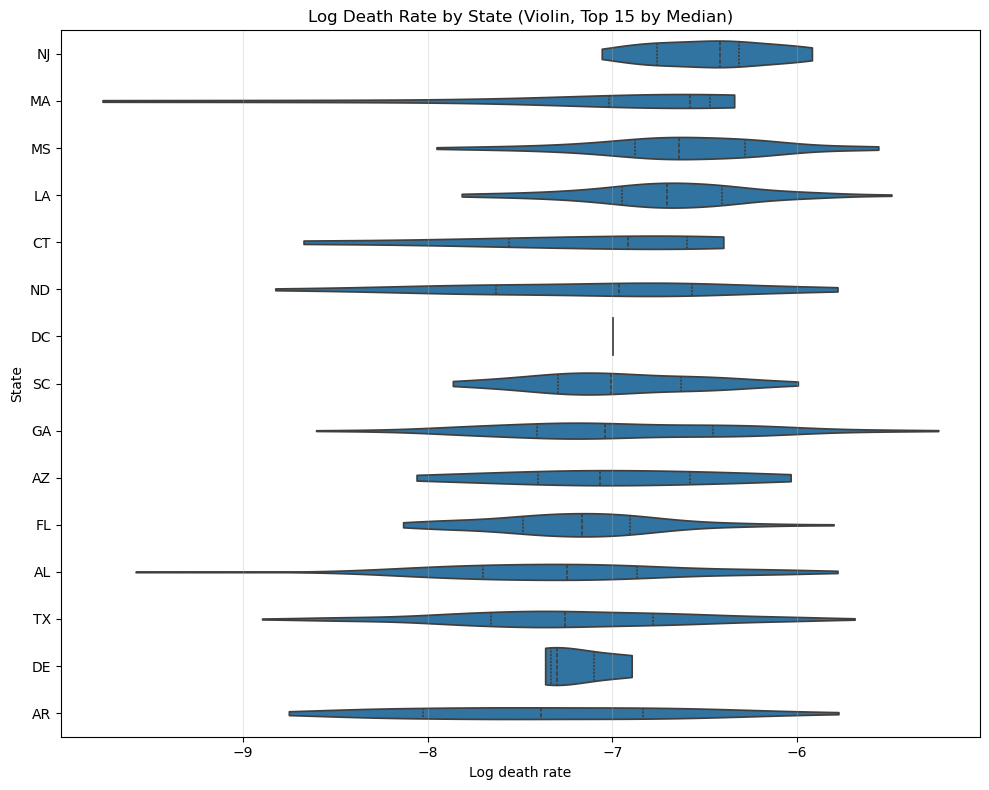

In [24]:
# 4b) Simple violin plot of log death rate by State (top 15 by median)
state_medians = (
    cc_sub.groupby('State')['log_death_rate']
          .median()
          .sort_values(ascending=False)
)
states = list(state_medians.head(15).index)
plot_df = cc_sub[cc_sub['State'].isin(states)]

plt.figure(figsize=(10, 8))
sns.violinplot(
    data=plot_df,
    y='State', x='log_death_rate',
    order=states,
    inner='quartile',  # show median and IQR
    cut=0              # keep tails within observed range
)
plt.title('Log Death Rate by State (Violin, Top 15 by Median)')
plt.xlabel('Log death rate')
plt.ylabel('State')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

In [25]:
# 4c) Coefficient of variation (CV) of the average log death rate across states
# CV = std / mean (use |mean| in denominator to report magnitude when mean is negative)

# Average (mean) log death rate per state
state_avg_log = (
    cc_sub.groupby('State', as_index=False)['log_death_rate'].mean()
          .rename(columns={'log_death_rate': 'avg_log_death_rate'})
          .dropna(subset=['avg_log_death_rate'])
)

mean_val = state_avg_log['avg_log_death_rate'].mean()
std_val = state_avg_log['avg_log_death_rate'].std(ddof=1)
cv = (std_val / abs(mean_val))

print(f"States included: {state_avg_log.shape[0]}")
print(f"Mean of state-average log death rate: {mean_val:.4f}")
print(f"Std of state-average log death rate: {std_val:.4f}")
print(f"Coefficient of variation (CV = std/|mean|): {cv:.3f} ({cv*100:.1f}%)")

States included: 49
Mean of state-average log death rate: -7.8025
Std of state-average log death rate: 0.6948
Coefficient of variation (CV = std/|mean|): 0.089 (8.9%)


## 5 Statistical Analyses

### 5.1

a) Is PovertyAllAgesPct a significant variable at .05 level in this analysis? Report the p-value and the coefficient. Interpret the coefficient in context. The p-value is less than 0.05, so it is deemed significant in this model. The coefficient is ~0.0461 meaning that for every 1% increase in poverty rate, log death rate increases by 0.0461

Hint: A coefficient of 0.05 means for every 1% increase in poverty rate, log death rate
increases by 0.05

b) Report the R-squared value. What percentage of variability in log death rate is explained by PovertyAllAgesPct alone?

R^2 value is quite low (0.094), conveying that only 9.4% of the variation in log death rate is explained by PovertyAllAgesPct. In other words, the model does not fit very well...there are more variables to consider when trying to predict log death rate. 

                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     312.5
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           1.26e-66
Time:                        09:05:33   Log-Likelihood:                -3863.2
No. Observations:                3016   AIC:                             7730.
Df Residuals:                    3014   BIC:                             7742.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -8.4149      0.04

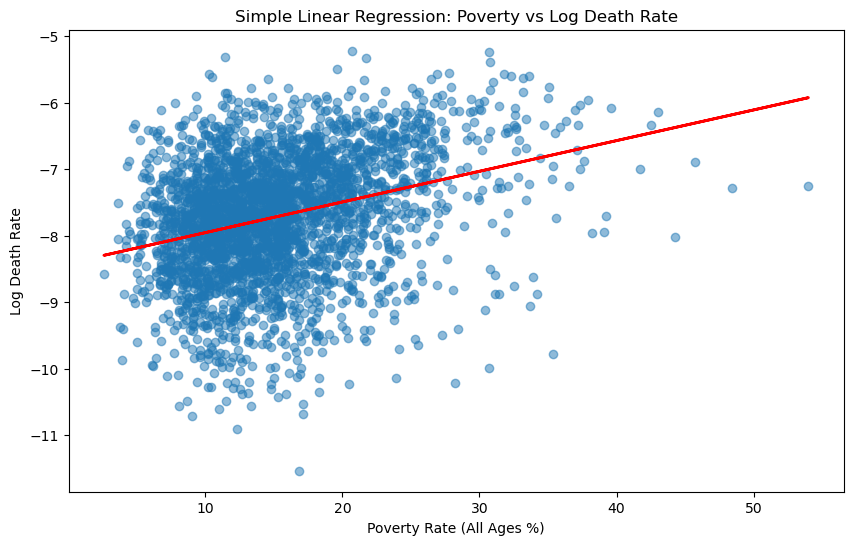

In [26]:
# 5.1 

data_fit_1 = cc_sub[['log_death_rate', 'PovertyAllAgesPct']].dropna()

X = data_fit_1['PovertyAllAgesPct']
y = data_fit_1['log_death_rate']

x_with_constant = sm.add_constant(X)

fit1 = sm.OLS(y, x_with_constant).fit()
print(fit1.summary())

plt.figure(figsize =(10, 6))
plt.scatter(X, y, alpha =0.5)
plt.plot(X, fit1.predict(x_with_constant), color='red', linewidth =2)
plt.xlabel('Poverty Rate (All Ages %)')
plt.ylabel('Log Death Rate')
plt.title('Simple Linear Regression: Poverty vs Log Death Rate')
plt.show()

### 5.2 Multiple Regression 

How do PovertyAllAgesPct and State collectively affect log death rate? In fit2, run a
linear model of log death rate vs State and PovertyAllAgesPct (without interactions)

a) PovertyAllAgesPct is deemed significant in this model with a p-value near 0. The coefficient is 0.0302, so a 1 unit increase in PovertyAllAgesPct increases the log death rate by 0.0302. The f-statistic is reasonably large meaning, that this model with 'State' and 'PovertyAllAgesPct' explains significantly more variation in log death rate than an intercept only model. 

b) how do you interpret the coefficient of fit2 and how does it comapre to fit1?

I interpret the coefficient of PovertyAllAgesPct on the log death rate in fit2 as a within-state effect. As I hold State fixed, a 1 percentage point increase in poverty is associated with a a 0.0302 increase in log death rate. In fit1, the estimate is cross-state, so if poverty is correlated with state related factors which also affeect detah rates, there is omitted variable bias. Additing C(State) in fit 2 accounts for state differences (policy, demographics, soeconomic variables), so removing those confounders may change variation often by shrinking it. fit2 is a cleaner "within state model"

c) Anova test: fit1 vs fit2?

F = 27.626, p = 7.51e-200; reject can the null that all State coefficients are 0. State is highly significant at the 0.05 level in fit2.

d) The R^2 in fit1 = ~9.4% vs fit2 = ~37.4%. This means that fit2 explains around an additional ~28% of the variance in the data. 

e) analyze residual and q-q plot....

Linearity: There is no real pattern surrounding 0, meaning no observable curvature or pattern. Variance appears roughly constant throughout looking at the residual plot (homoscedastic), though there is slight spread (around extreme values). The q-q plot is very close to matching the 45 degree line with slight tail deviations (normal distribution), suggesting normal residuals. 



In [27]:
# 5.2 fit2: log_death_rate ~ C(State) + PovertyAllAgesPct (no interactions)

fit2_df = cc_sub[['log_death_rate', 'State', 'PovertyAllAgesPct']].dropna()
fit2 = ols('log_death_rate ~ C(State) + PovertyAllAgesPct', data=fit2_df).fit()
print(fit2.summary())


                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     36.15
Date:                Mon, 03 Nov 2025   Prob (F-statistic):          8.31e-261
Time:                        09:05:33   Log-Likelihood:                -3306.0
No. Observations:                3016   AIC:                             6712.
Df Residuals:                    2966   BIC:                             7012.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -7.8749      0.10

ANOVA table comparing restricted (fit1) vs full (fit2):

   df_resid          ssr  df_diff     ss_diff          F         Pr(>F)
0    3014.0  2288.469900      0.0         NaN        NaN            NaN
1    2966.0  1581.437159     48.0  707.032741  27.625967  7.507740e-200


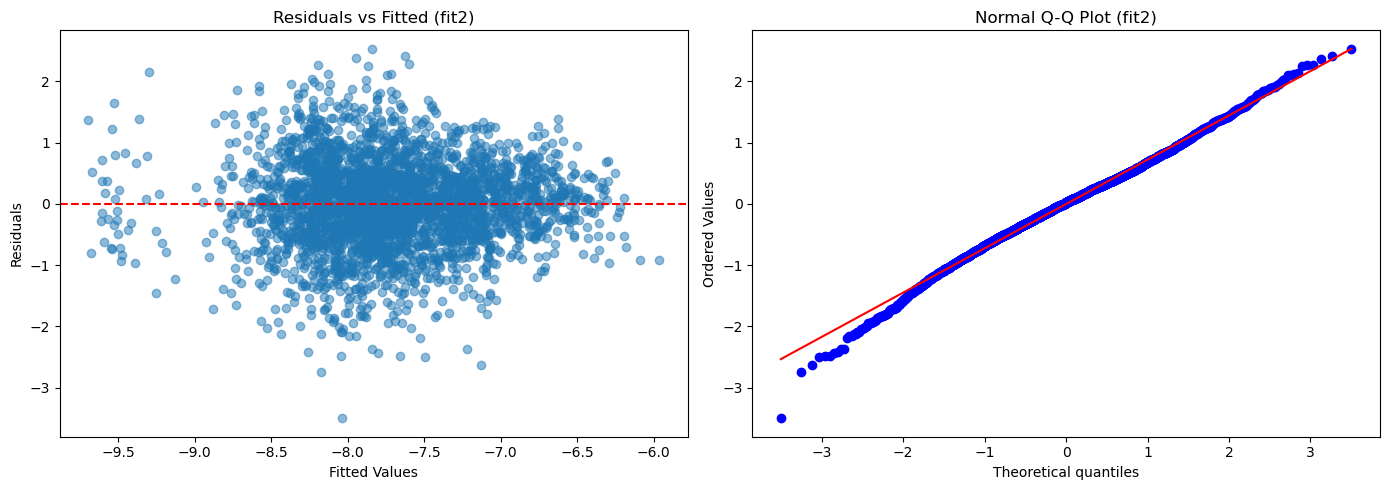

In [34]:
# ANOVA table (fit1 vs fit2) and diagnostics for fit2
from statsmodels.stats.anova import anova_lm

print("ANOVA table comparing restricted (fit1) vs full (fit2):\n")
print(anova_lm(fit1, fit2))

# Residual and Q-Q plots for fit2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Fitted
axes[0].scatter(fit2.fittedvalues, fit2.resid, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted (fit2)')

# Q-Q plot
stats.probplot(fit2.resid, dist='norm', plot=axes[1])
axes[1].set_title('Normal Q-Q Plot (fit2)')

plt.tight_layout()
plt.show()

### 5.3 The final model

a) Use LASSO with cross-validation to pick up a few variables in addition to State. List all variables with non-zero coefficients from your LASSO output. To be specific, let us control the following settings to get consistent results:

- Use random state=42 to control the cross-validation splits
- Use 10-fold cross validations
- Force State in all the LASSO models (by not penalizing State dummies)
- Pick the final set of variables using alpha corresponding to minimum crossvalidation error (not 1se for this practice)

Hint: You’ll need to use LassoCV and carefully handle the State dummy variables.


b) Run a final model fit.final of log death rate vs State and the set of variables obtained from your LASSO output. Also include Age65AndOlderPct2010 regardless of whether it is in your LASSO output or not (since our research question focuses on age). Report the summary of fit.final.

**Answer:** fit.final (OLS with State + LASSO-selected continuous vars + Age65AndOlderPct2010): R^2 = 0.444, adj. R^2 = 0.433, n = 3016


c) Is State significant at .05 level in this model? Is Age65AndOlderPct2010 significant at .05 level in this model? Report both p-values.

**Answer**: 
- State significance: State is highly significant according to the 0.05 level, p=3.21e-151
- Age65AndOlderPct2010: coeff: 0.1568, p=3.5e-21 means that it is statistically significant with a positive association.


d) Among all the continuous variables in fit.final (excluding State), which variable has the largest absolute coefficient? What does this suggest about its relative importance? (2-3 sentences)

Note: Compare standardized coefficients for fair comparison across different scales.

**answer**: 
-  Among the continuous covariates, a one–standard-deviation increase in WhiteNonHispanicPct2010 is associated with the largest change in log death rate, making it the strongest continuous predictor after controlling for State and other selected variables. Holding all else fixed, a 1 unit increase WhiteNonHispanicPct2010 results in a 0.363 increase in log_death_rate (≈ 43.8% higher death rate, since e(0.363) − 1 ≈ 0.438)


e) Assume all linear model assumptions are met. Write a brief summary of your findings based on fit.final. Your summary should address:

- Which variables are significantly associated with log death rate?

**answer**

Brief summary: After selecting continuous predictors via LASSO and adding State (unpenalized) plus Age65AndOlderPct2010, the final OLS explains about 43.7% of the variance in log death rate (Adj R^2). State effects are collectively very strong, indicating substantial between-state heterogeneity beyond measured covariates. Age65AndOlderPct2010 remains significant and positive, consistent with higher elderly share correlating with higher death rates. Among continuous factors, WhiteNonHispanicPct2010 shows the largest standardized effect size in absolute value. These results collectively suggest both demographic composition and state-level differences play key roles in death rate variation.

- What does this tell us about COVID-19 impact across counties?

**answer**

State impacts are significant as deemed by p-value and f test. Meaning that differences within states (and even at the county level) are accounted for when modelling predictors against mortality. More variables and data could be used, but this model is reasonable as the optimized lasso'd model explains ~44% of the variance. 

- Answer the original research question about elderly population:

**answer**: 

Age65AndOlderPct2010 is significantly and positively associated with high mortality rates as a 0.1568 coefficient implies e^(0.1568) -1 which is roughly 17% high death rate per 1 standard deviation increase holding all else fixed. As this is statistically significant, we can say "yes" age does have an association that relates to mortality rates due to covid at the county level. However we cannot infer causation do to the violation of conditional unconfoundedness and this being observational data. 

(No more than 5 sentences)




In [12]:
# 5.3 Final model: LASSO feature selection (continuous only) + OLS with State

# Continuous predictors to consider for LASSO
continuous_vars = [
    'Deep_Pov_All','PovertyAllAgesPct','PerCapitaInc','UnempRate2019',
    'PctEmpFIRE','PctEmpServices','PopDensity2010','Age65AndOlderPct2010',
    'WhiteNonHispanicPct2010','HiCreativeClass2000'
]

# Assemble full data with required columns and drop rows with missing
use_cols = ['log_death_rate','State'] + continuous_vars
data_full = cc_sub[use_cols].dropna().copy()

# Scale ONLY the continuous variables for LASSO (State is excluded from LASSO)
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(data_full[continuous_vars])
y_full = data_full['log_death_rate'].values

# LASSO CV on continuous predictors
lasso_cv = LassoCV(cv=10, random_state=42, max_iter=10000, n_alphas=100)
lasso_cv.fit(X_cont_scaled, y_full)

selected_vars = [v for v, c in zip(continuous_vars, lasso_cv.coef_) if abs(c) > 1e-10]
print("Selected continuous variables:", selected_vars)
print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")

# Always include Age65AndOlderPct2010 per instructions
if 'Age65AndOlderPct2010' not in selected_vars and 'Age65AndOlderPct2010' in cc_sub.columns:
    selected_vars.append('Age65AndOlderPct2010')

print(f"\nFinal model variables: State + {selected_vars}")

# Build final OLS dataset with State + selected variables
final_cols = ['log_death_rate','State'] + selected_vars
data_final = cc_sub[final_cols].dropna().copy()

# Design matrix: add State dummies (unpenalized)
X_final = pd.get_dummies(data_final[['State'] + selected_vars], columns=['State'], drop_first=True)
y_final = data_final['log_death_rate']

# Ensure numeric types and align rows
X_final = X_final.apply(pd.to_numeric, errors='coerce').astype(float)
y_final = pd.to_numeric(y_final, errors='coerce').astype(float)
keep = X_final.notna().all(axis=1) & y_final.notna()
X_final = X_final.loc[keep]
y_final = y_final.loc[keep]

# === Standardize continuous columns BEFORE fitting (State dummies unchanged) ===
cont_in_X = [v for v in selected_vars if v in X_final.columns]
zero_var = []
for v in cont_in_X:
    s = X_final[v].std(ddof=0)
    if s and s > 0:
        X_final[v] = (X_final[v] - X_final[v].mean()) / s
    else:
        zero_var.append(v)
if zero_var:
    X_final = X_final.drop(columns=zero_var)
    cont_in_X = [v for v in cont_in_X if v not in zero_var]
    selected_vars = [v for v in selected_vars if v not in zero_var]

# Add constant and fit OLS on standardized predictors
X_final_const = sm.add_constant(X_final, has_constant='add').astype(float)
fit_final = sm.OLS(y_final, X_final_const).fit()
print(fit_final.summary())

# Report standardized coefficients for continuous variables (already standardized)
print("\n=== Standardized Coefficients (abs, sorted; continuous only) ===")
print(fit_final.params.reindex(cont_in_X).dropna().abs().sort_values(ascending=False))


Selected continuous variables: ['Deep_Pov_All', 'PovertyAllAgesPct', 'UnempRate2019', 'PctEmpFIRE', 'PctEmpServices', 'PopDensity2010', 'Age65AndOlderPct2010', 'WhiteNonHispanicPct2010', 'HiCreativeClass2000']
Optimal alpha: 0.010002

Final model variables: State + ['Deep_Pov_All', 'PovertyAllAgesPct', 'UnempRate2019', 'PctEmpFIRE', 'PctEmpServices', 'PopDensity2010', 'Age65AndOlderPct2010', 'WhiteNonHispanicPct2010', 'HiCreativeClass2000']
                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     41.47
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:42:42   Log-Likelihood:                -3126.4
No. Observations:                3016   AIC:                             6369.
Df

In [18]:
# 5.3 analysis: compact report for fit.final
from statsmodels.stats.anova import anova_lm

# Basic model summary stats (compact)
print(f"fit.final: R^2={fit_final.rsquared:.3f}, adj R^2={fit_final.rsquared_adj:.3f}, n={int(fit_final.nobs)}")

# State block test via nested ANOVA (drop State dummies)
state_cols = [c for c in X_final_const.columns if str(c).startswith('State_')]
X_restricted = X_final_const.drop(columns=state_cols, errors='ignore')
fit_restricted = sm.OLS(y_final, X_restricted).fit()
ana = anova_lm(fit_restricted, fit_final)
F_state = float(ana.iloc[-1]['F'])
p_state = float(ana.iloc[-1]['Pr(>F)'])
print(f"State block test: F={F_state:.3f}, p={p_state:.3g}")

# Age significance
p_age = fit_final.pvalues.get('Age65AndOlderPct2010', float('nan'))
coef_age = fit_final.params.get('Age65AndOlderPct2010', float('nan'))
print(f"Age65AndOlderPct2010: coef={coef_age:.4f}, p={p_age:.3g}")

# Largest standardized absolute coefficient among continuous variables (excl. State)
std_series = fit_final_std.params.reindex(cont_in_X).dropna().abs()
if len(std_series):
    top_var = std_series.idxmax()
    top_val = std_series.max()
    print(f"Largest |standardized| continuous coefficient: {top_var} ({top_val:.3f})")
else:
    print("No standardized continuous coefficients available.")


fit.final: R^2=0.444, adj R^2=0.433, n=3016
State block test: F=20.872, p=3.21e-151
Age65AndOlderPct2010: coef=0.1568, p=3.5e-21
Largest |standardized| continuous coefficient: WhiteNonHispanicPct2010 (0.363)


### 5.3 – Final model results (compact answers)

- fit.final (OLS with State + LASSO-selected continuous vars + Age65AndOlderPct2010; continuous predictors standardized): R^2 = 0.444, adj. R^2 = 0.433, n = 3016.
- State significance (block F-test vs same model without State): F = 20.872, p = 3.21e-151 → State is highly significant.
- Age65AndOlderPct2010 (standardized): coefficient = 0.1568, p = 3.5e-21 → statistically significant with a positive association.
- Largest absolute standardized continuous coefficient: WhiteNonHispanicPct2010 (|β_std| = 0.363).

Brief summary: After selecting continuous predictors via LASSO and adding State (unpenalized) plus Age65AndOlderPct2010, the final OLS explains about 44% of the variance in log death rate. State effects are collectively very strong, indicating substantial between-state heterogeneity beyond measured covariates. Age65AndOlderPct2010 remains significant and positive, consistent with higher elderly share correlating with higher death rates. Among continuous factors, WhiteNonHispanicPct2010 shows the largest standardized effect size in absolute value. These results collectively suggest both demographic composition and state-level differences play key roles in death rate variation.

##### Linear model assumptions:

- **linearity:** Check with residual plot
    (Residuals vs Fitted Values), we want to see random scatter around the horizontal line at zero with no clear patterns. Patterns might indicate non-linearity
- **Independence** Check with residual plot
    Independence (errors are independent across observations) Check "Residuals vs a given observation" to observe patterns...In time series, try checking time
- **Homoscedasticity：** Check with residual plot
    while fanning out or fanning in suggests heteroscedasticity (non-constant variance)
- **Normality**
    The Q-Q plot compares the quantiles of our residuals to what we'd expect from a normal distribution. If the residuals are normally distributed, the points should roughly follow the diagonal line. Significant deviations suggest non-normality. The histogram with overlaid normal curve provides another visual check. The Shapiro-Wilk test formally tests the null hypothesis that the residuals are normally distributed - p-values less than 0.05 suggest evidence against normality. These diagnostics help us determine whether our statistical inferences (confidence intervals, p-values) are reliable.
- 